## Applied ML for baseball:

#### By Thomas Maxence Franco 
Submitted to the Faculty of Science in partial fulfillment of the requirements for the degree of 
#### Master of Modeling for Science and Engineering 
at the 
#### UNIVERSITAT AUTÒNOMA DE BARCELONA 
Directed by 
Tomás Manuel Margalef Burrull
July 2024

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [2]:
file_path = "C:\\Users\\mfran\\OneDrive - UAB\\Masters\\Thesis\\Pitching\\adv\\Dataframes\\advperfpitch_all.csv"

try:
    df = pd.read_csv(file_path, encoding='latin1')
except UnicodeDecodeError:
    print("Error reading the file with 'latin1' encoding.")
    
df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,SIERA,xERA,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,3.663228,3.82,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,3.949935,3.66,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,3.445838,2.82,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,3.751155,3.71,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,3.817126,3.77,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          508 non-null    object 
 1   year          508 non-null    int64  
 2   AAV           508 non-null    float64
 3   minor_league  508 non-null    bool   
 4   SP            508 non-null    bool   
 5   RP            508 non-null    bool   
 6   Yrs           508 non-null    int64  
 7   W             508 non-null    int64  
 8   L             508 non-null    int64  
 9   ERA           508 non-null    float64
 10  WHIP          508 non-null    float64
 11  G             508 non-null    int64  
 12  GS            508 non-null    int64  
 13  QS            508 non-null    int64  
 14  SV            508 non-null    int64  
 15  BS            508 non-null    int64  
 16  HLD           508 non-null    int64  
 17  IP            508 non-null    float64
 18  SO            508 non-null    

On a previous step (in Excel) I created a few additional variables like Acc_G, VeloChange, Avg K/9, among others. The ones with Acc as a prefix are the sum of the same statistic in the two seasons. For example G + G_2 = Acc_G. 

For VeloChange I wanted to see the change in average mph thrown from one season to another. This will refelct if the pitcher is throwing faster or slower and we will see if teams pay attention to that. 

For the other variables with the suffix "Change" the thought process was the same. It will reflect the improvement (or otherwise) of the pitcher. 

### Handling the NULL values. 

In [4]:
columns = ['FIP', 'WAR', 'xFIP', 'WPA','SIERA', 'xERA', 'EV']

for column in columns:
    column_2 = f"{column}_2"
    
    df.loc[df[column_2].isnull() & df[column].notnull(), column_2] = df.loc[df[column_2].isnull() & df[column].notnull(), column]

    median_value = df[column].median()
    df.loc[df[column].isnull() & df[column_2].notnull(), column] = median_value

In [5]:
df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,SIERA,xERA,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,3.663228,3.82,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,3.949935,3.66,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,3.445838,2.82,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,3.751155,3.71,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,3.817126,3.77,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 67 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          508 non-null    object 
 1   year          508 non-null    int64  
 2   AAV           508 non-null    float64
 3   minor_league  508 non-null    bool   
 4   SP            508 non-null    bool   
 5   RP            508 non-null    bool   
 6   Yrs           508 non-null    int64  
 7   W             508 non-null    int64  
 8   L             508 non-null    int64  
 9   ERA           508 non-null    float64
 10  WHIP          508 non-null    float64
 11  G             508 non-null    int64  
 12  GS            508 non-null    int64  
 13  QS            508 non-null    int64  
 14  SV            508 non-null    int64  
 15  BS            508 non-null    int64  
 16  HLD           508 non-null    int64  
 17  IP            508 non-null    float64
 18  SO            508 non-null    

In [7]:
df['Acc_WAR'] = df['WAR'] + df['WAR_2']

df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,xERA,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,3.82,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312,7.966784
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,3.66,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132,7.645342
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,2.82,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631,5.001775
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,3.71,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850,10.192750
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,3.77,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630,6.191165


In [8]:
df['Acc_WPA'] = df['WPA'] + df['WPA_2']

df.head()

,Name,year,AAV,minor_league,SP,RP,Yrs,W,L,ERA,...,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA
0,Shohei Ohtani,2024,34.877193,False,True,False,6,10,5,3.136364,...,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312,7.966784,5.364157
1,Sonny Gray,2024,25.000000,False,True,False,11,8,8,1.790000,...,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132,7.645342,3.818644
2,Brandon Woodruff,2024,8.750000,False,True,False,7,5,1,2.283582,...,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631,5.001775,3.346239
3,Aaron Nola,2024,24.571429,False,True,False,9,12,9,4.460000,...,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850,10.192750,2.951880
4,Clayton Kershaw,2024,5.000000,False,True,False,16,13,5,2.460000,...,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630,6.191165,4.462551


## Feature Selection

In [9]:
removed_columns = ['PlayerId', 'year']
used_columns = df.columns[~df.columns.isin(removed_columns)]

df2 = df.drop(columns=removed_columns).copy()

df2.head()

,Name,AAV,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,...,EV,FIP_2,WAR_2,xFIP_2,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA
0,Shohei Ohtani,34.877193,False,True,False,6,10,5,3.136364,1.060606,...,86.378451,2.401588,5.598513,2.651803,3.405847,2.733153,2.68,87.126312,7.966784,5.364157
1,Sonny Gray,25.000000,False,True,False,11,8,8,1.790000,1.150000,...,89.132116,3.404910,2.360812,3.657305,0.810078,3.731328,3.67,88.050132,7.645342,3.818644
2,Brandon Woodruff,8.750000,False,True,False,7,5,1,2.283582,0.820896,...,89.024346,3.079822,3.554962,3.137087,2.104717,3.025599,3.15,88.674631,5.001775,3.346239
3,Aaron Nola,24.571429,False,True,False,9,12,9,4.460000,1.150000,...,89.281106,2.580724,6.312604,2.769559,2.400706,2.802457,2.74,87.699850,10.192750,2.951880
4,Clayton Kershaw,5.000000,False,True,False,16,13,5,2.460000,1.060000,...,89.026886,2.566257,3.849776,2.826209,2.550616,2.982783,2.51,87.098630,6.191165,4.462551


### Correlation Matrix

In [10]:
numerical_columns = df2.select_dtypes(include=['number']).columns
boolean_columns = df2.select_dtypes(include=['bool']).columns

selected_columns = numerical_columns.union(boolean_columns)

correlation_matrix = df2[selected_columns].corr()

correlation_matrix.style.background_gradient("coolwarm", vmin=-1, vmax=1)

,AAV,Acc_BS,Acc_G,Acc_GS,Acc_HLD,Acc_IP,Acc_QS,Acc_SO,Acc_SV,Acc_WAR,Acc_WPA,BB/9,BB/9Change,BB/9_2,BS,BS_2,ERA,ERAChange,ERA_2,EV,EV_2,FBv,FBv_2,FIP,FIP_2,G,GS,GS_2,G_2,HLD,HLD_2,HR/9,HR/9Change,HR/9_2,IP,IP_2,K/9,K/9Change,K/9_2,L,L_2,QS,QS_2,RP,SIERA,SIERA_2,SO,SO_2,SP,SV,SV_2,VeloChange,W,WAR,WAR_2,WHIP,WHIP_2,WPA,WPA_2,W_2,Yrs,minor_league,xERA,xERA_2,xFIP,xFIP_2
AAV,1.000000,-0.141774,-0.126680,0.481221,-0.231492,0.520056,0.588713,0.699078,0.109195,0.833589,0.536313,-0.233117,-0.055092,-0.186281,-0.093451,-0.157158,-0.268117,-0.122536,-0.139335,-0.065243,-0.047599,0.113450,0.157481,-0.342961,-0.230013,-0.055656,0.519264,0.374161,-0.164019,-0.164574,-0.237728,-0.140803,-0.079534,-0.029122,0.571719,0.314843,0.305915,0.020352,0.283678,0.310883,0.228153,0.642682,0.417008,-0.503318,-0.324951,-0.252234,0.720249,0.496335,0.408327,0.137674,0.068189,0.102403,0.621211,0.792543,0.630495,-0.331762,-0.226860,0.522665,0.311268,0.377868,0.146390,-0.351841,-0.316110,-0.184885,-0.437135,-0.347564
Acc_BS,-0.141774,1.000000,0.812708,-0.634561,0.616946,-0.410425,-0.566434,-0.298466,0.633576,-0.237913,0.192244,0.146751,0.083055,0.062090,0.883594,0.889483,-0.125227,0.066524,-0.250117,-0.108704,-0.128376,-0.020287,0.300204,-0.127850,-0.266038,0.702755,-0.570479,-0.605002,0.719721,0.560144,0.518228,-0.091571,0.071300,-0.182483,-0.340680,-0.354653,0.291783,-0.060503,0.349334,-0.222667,-0.220568,-0.484358,-0.525610,0.526251,-0.279831,-0.399019,-0.257121,-0.260068,-0.638076,0.557238,0.603441,-0.041506,-0.265322,-0.232426,-0.173673,-0.107750,-0.199297,0.104805,0.194086,-0.263054,-0.002054,-0.040098,-0.229198,-0.301249,-0.107119,-0.234637
Acc_G,-0.126680,0.812708,1.000000,-0.582224,0.753202,-0.279932,-0.507681,-0.179002,0.527385,-0.180348,0.276683,0.101128,0.030352,0.073450,0.711320,0.729511,-0.202499,0.045021,-0.310926,-0.163542,-0.190928,-0.027393,0.223850,-0.189869,-0.289734,0.870062,-0.523876,-0.554664,0.880433,0.673839,0.642186,-0.152845,0.054407,-0.218708,-0.235752,-0.238637,0.274215,-0.060196,0.331589,-0.184301,-0.185113,-0.432414,-0.472673,0.545955,-0.319330,-0.424798,-0.149673,-0.160305,-0.653245,0.479207,0.489085,-0.043223,-0.227657,-0.172050,-0.135822,-0.166929,-0.226370,0.183001,0.247187,-0.205963,0.056540,-0.088472,-0.289357,-0.350144,-0.154328,-0.250672
Acc_GS,0.481221,-0.634561,-0.582224,1.000000,-0.601443,0.907760,0.939304,0.817930,-0.366382,0.619242,-0.064570,-0.171970,-0.017526,-0.163786,-0.531575,-0.592849,0.091363,-0.011623,0.127290,0.095128,0.102142,0.058908,-0.238489,0.125400,0.140331,-0.493388,0.924731,0.928294,-0.525290,-0.528124,-0.522234,0.156057,-0.010720,0.163709,0.797598,0.742041,-0.214121,-0.041212,-0.171981,0.666432,0.631833,0.829081,0.847583,-0.772785,0.285694,0.285029,0.702931,0.714320,0.854608,-0.314119,-0.355939,0.075794,0.674827,0.523887,0.533733,0.034571,0.034934,-0.037466,-0.062926,0.680238,0.143710,-0.250167,0.197667,0.168238,0.080207,0.078280
Acc_HLD,-0.231492,0.616946,0.753202,-0.601443,1.000000,-0.402688,-0.539657,-0.342750,0.071809,-0.268268,0.178701,0.081621,-0.004294,0.092122,0.520482,0.572817,-0.154758,0.026855,-0.226331,-0.170430,-0.189569,-0.023972,0.150271,-0.162727,-0.225954,0.644909,-0.543221,-0.570969,0.673170,0.865747,0.880019,-0.146655,0.060236,-0.220529,-0.345263,-0.337395,0.212162,0.017294,0.193608,-0.285006,-0.293425,-0.461621,-0.500614,0.488927,-0.268454,-0.300231,-0.291173,-0.302570,-0.588694,0.075846,0.057480,-0.034603,-0.315886,-0.230521,-0.227633,-0.131620,-0.141316,0.133717,0.144134,-0.305982,-0.008491,-0.010688,-0.236169,-0.240106,-0.126094,-0.165554
Acc_IP,0.520056,-0.410425,-0.279932,0.907760,-0.402688,1.000000,0.899327,0.878631,-0.211825,0.668107,0.050438,-0.183798,-0.006622,-0.188862,-0.323258,-0.403507,0.019992,0.004671,0.017067,0.042356,0.037553,0.054952,-0.208084,0.061379,0.026663,-0.222325,0.840654,0.841476,-0.266887,-0.338316,-0.364157,0.116713,0.020278,0.084823,0.840641,0.853954,-0.154101,-0.068418,-0.085575,0.677465,0.649765,0.795062,0.810333,-0.657816,0.190785,0.148103,0.753

In [11]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df2[['Acc_WAR', 'WAR', 'WAR_2']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


   feature       VIF
0    const  1.791902
1  Acc_WAR       inf
2      WAR       inf
3    WAR_2       inf


C:\Users\mfran\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


The output shows infinite VIF values for Acc_WAR, WAR, and WAR_2, indicating perfect multicollinearity among these variables. This is expected because Acc_WAR is a direct linear combination of WAR and WAR_2.

Given this result, it is clear that we should not include all three variables in the model simultaneously. Including highly collinear variables can lead to issues in the model.

I will retain Only Acc_WAR: Since Acc_WAR has the highest correlation with the target variable and encapsulates the information from both WAR and WAR_2, the best approach would be to use only Acc_WAR and exclude WAR and WAR_2.


The same process will be done for the 'Acc' variables and also the ones ending in '_2'. Only the one with the highest colinearity will be kept. 



Im going to run one model with all of the variables and then use it as reference for improvement. 

## Train-test split

For the train test we will be using different combinations: 80-20 and 70-30. This is the 80-20 version as the file name states. The results will be kept in different tables for comparison. To obtain this we modify 'test_size=0.2' 0.2 or 0.3 depending on the combination.

In [12]:
target = "AAV"
features = [col for col in df2.columns if col != target and col!= "Name"]
X, y = df2[features], df2[target]

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (355, 65)
X_test shape: (153, 65)
y_train shape: (355,)
y_test shape: (153,)


C:\Users\mfran\AppData\Local\Temp\ipykernel_13500\3840007699.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, shade=True)


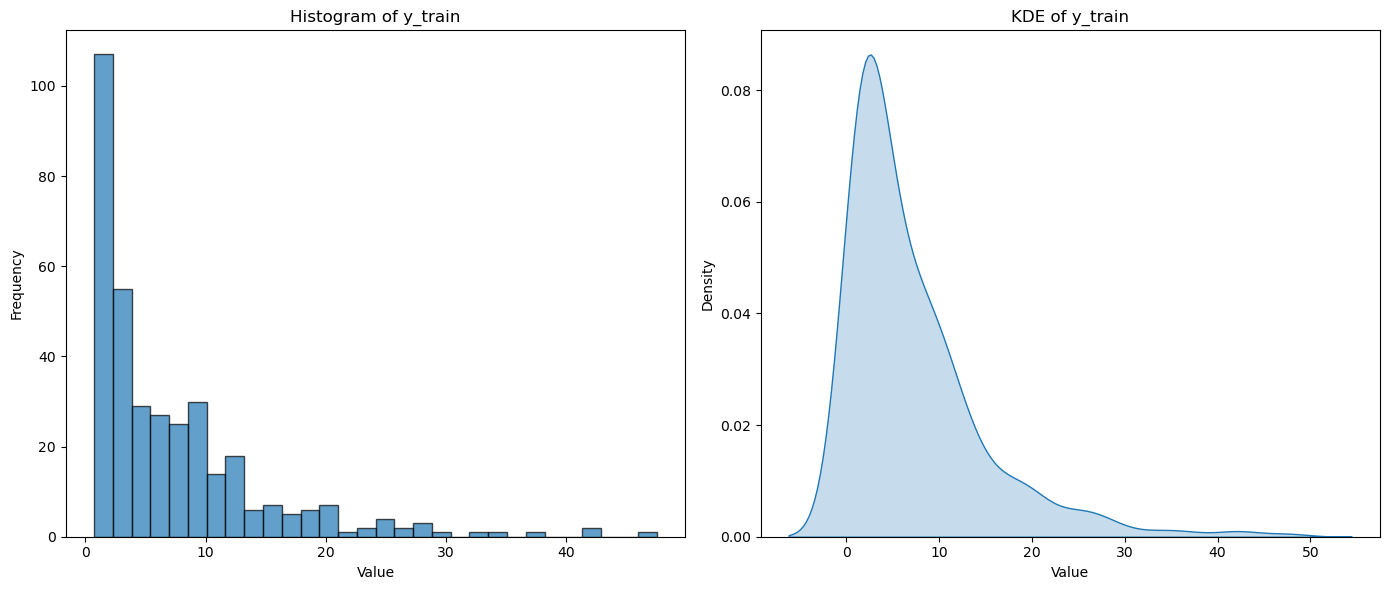

In [14]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_train, shade=True)
plt.title('KDE of y_train')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

C:\Users\mfran\AppData\Local\Temp\ipykernel_13500\893388450.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, shade=True)


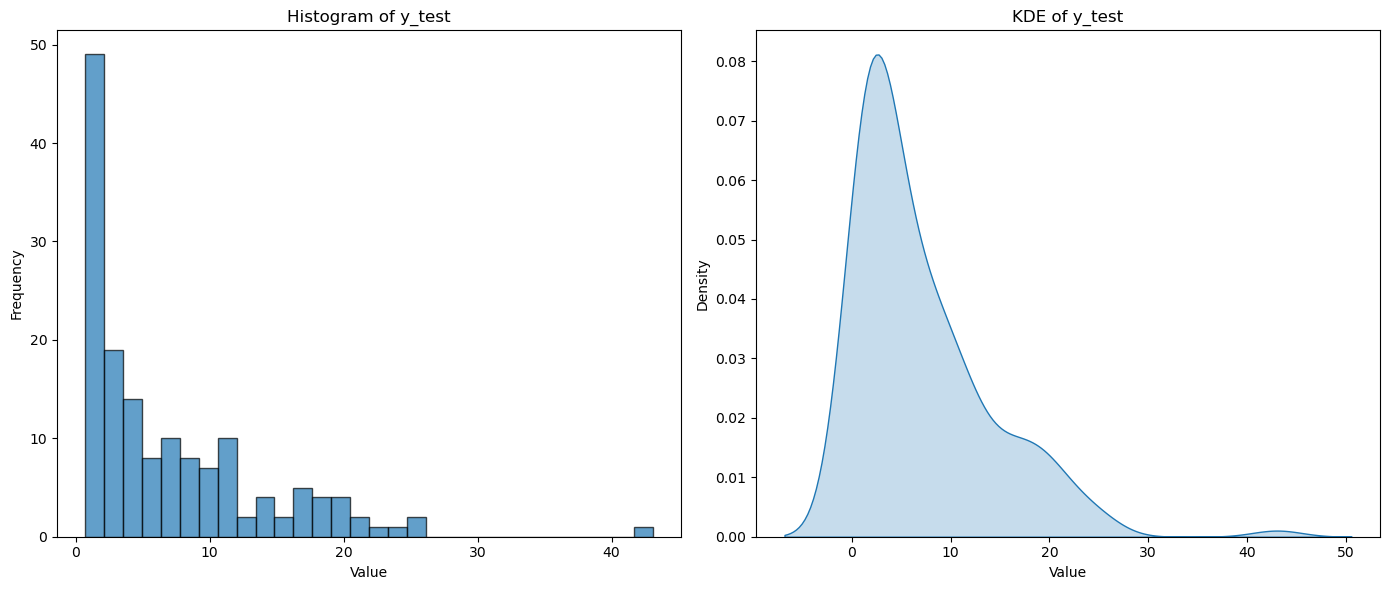

In [15]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_test, shade=True)
plt.title('KDE of y_test')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

## Linear Model (with all variables)

In [16]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [17]:
linear_model.coef_, linear_model.intercept_

(array([-1.42344850e+00,  6.44954600e-01, -1.07731132e+00,  1.12228715e-01,
        -6.90408288e-02,  2.89610057e-02,  6.16343294e+07, -5.65032684e-01,
        -1.18521689e+02,  2.52113131e+02,  5.08077113e+01, -9.89468391e+01,
         2.98067403e+01, -5.32443848e+01, -6.13664509e+02,  1.47115007e+02,
        -3.19648987e+01, -1.83485599e+01,  1.41456063e+01,  1.18263383e+01,
        -1.06332487e-01,  2.80815256e-02, -6.16343298e+07, -2.94534248e-01,
        -1.18451426e+02,  2.52311910e+02,  5.08285139e+01, -9.90430568e+01,
         2.97545127e+01, -5.32709756e+01, -6.13673510e+02,  1.47052356e+02,
         3.13206986e+01,  1.97970195e+01, -1.21825604e+01, -1.15012575e+01,
         6.13668804e+02, -1.47056398e+02,  1.18435792e+02, -2.52282787e+02,
        -5.07506793e+01,  9.90338561e+01, -2.97023178e+01,  5.32800076e+01,
        -6.16343296e+07, -1.18245324e+01,  3.19381782e+01,  1.89429403e+01,
        -1.43988760e+01,  1.01534844e+00,  2.59646711e+01, -1.64940055e-01,
        -2.1

In [18]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,12,1,1,5.094341,1.556604,37,0,...,-0.406518,5.300887,6.09,85.801338,0.019265,-1.224556,1.479137,-3.384828,4.863965,328.838020
344,False,True,False,6,2,2,4.940000,1.260000,7,7,...,-0.581658,4.603308,5.03,89.231379,0.872343,-0.479032,4.160566,5.385082,-1.224515,-29.431452
47,False,False,True,9,7,2,3.281768,1.193370,61,0,...,-0.061196,5.461969,4.78,90.073819,-0.332473,-0.449046,4.500000,6.330858,-1.830858,-40.685738
67,False,False,True,7,2,2,3.375000,1.243421,51,0,...,-0.470414,3.680546,5.38,87.570701,-0.194070,-0.170446,6.000000,7.440976,-1.440976,-24.016260
363,False,True,True,10,7,9,3.570000,1.290000,36,30,...,-2.176972,5.571353,6.70,88.543539,1.432180,-2.293026,8.321133,8.985154,-0.664021,-7.979935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,True,False,12,2,2,3.160000,1.220000,9,8,...,1.490762,4.518217,4.09,85.657067,3.568354,1.046226,4.474045,8.712206,-4.238161,-94.727713
122,True,False,True,9,4,5,4.013514,1.601352,55,0,...,1.432300,4.192814,3.37,88.547549,0.899570,1.225240,0.745674,2.658190,-1.912516,-256.481427
260,False,True,False,9,10,11,3.810000,1.320000,33,33,...,0.837590,4.668484,4.48,88.653106,2.358952,2.477630,10.688667,7.018008,3.670659,34.341595
23,False,True,False,8,8,7,3.567198,1.202734,26,26,...,-0.017154,3.135680,3.46,88.450960,3.064483,0.838518,15.000000,13.607797,1.392203,9.281352


### Evaluation Metrics

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 3.687209377295153
MAPE: 0.8131107945549695
R^2: 0.7117042338346311


#### Correction for negative predictions

In [20]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [21]:
linear_model = LinearRegression()

y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,12,1,1,5.094341,1.556604,37,0,...,-0.406518,5.300887,6.09,85.801338,0.019265,-1.224556,1.479137,0.554311,0.924826,62.524716
344,False,True,False,6,2,2,4.940000,1.260000,7,7,...,-0.581658,4.603308,5.03,89.231379,0.872343,-0.479032,4.160566,3.518526,0.642041,15.431574
47,False,False,True,9,7,2,3.281768,1.193370,61,0,...,-0.061196,5.461969,4.78,90.073819,-0.332473,-0.449046,4.500000,3.243535,1.256465,27.921455
67,False,False,True,7,2,2,3.375000,1.243421,51,0,...,-0.470414,3.680546,5.38,87.570701,-0.194070,-0.170446,6.000000,4.095500,1.904500,31.741670
363,False,True,True,10,7,9,3.570000,1.290000,36,30,...,-2.176972,5.571353,6.70,88.543539,1.432180,-2.293026,8.321133,6.793336,1.527796,18.360438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,True,False,12,2,2,3.160000,1.220000,9,8,...,1.490762,4.518217,4.09,85.657067,3.568354,1.046226,4.474045,6.379887,-1.905842,-42.597727
122,True,False,True,9,4,5,4.013514,1.601352,55,0,...,1.432300,4.192814,3.37,88.547549,0.899570,1.225240,0.745674,2.297709,-1.552035,-208.138466
260,False,True,False,9,10,11,3.810000,1.320000,33,33,...,0.837590,4.668484,4.48,88.653106,2.358952,2.477630,10.688667,5.899935,4.788732,44.801957
23,False,True,False,8,8,7,3.567198,1.202734,26,26,...,-0.017154,3.135680,3.46,88.450960,3.064483,0.838518,15.000000,7.540481,7.459519,49.730124


In [22]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 4.629005145668036
MAPE: 0.46267433320313406
R^2: 0.5456212710139561


### Evaluating per ranges

#### Testing 0-5 range values

In [23]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df['y_real_in_range'].sum()

correct_predictions = results_df['in_range'].sum()

print(f'Number of y_real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of y_real values in the range 0-5: 83
Number of correct predictions in the range 0-5: 73


#### All ranges visualized with a bar plot

   Range  Total_y_real_in_range  Correct_Predictions
0    0-5                     83                   73
1   5-10                     31                   17
2  10-15                     19                    5
3  15-20                     13                    1
4  20-25                      8                    2
5  25-30                      1                    0
6  30-35                      0                    0
7  35-40                      0                    0
8    40+                      1                    1


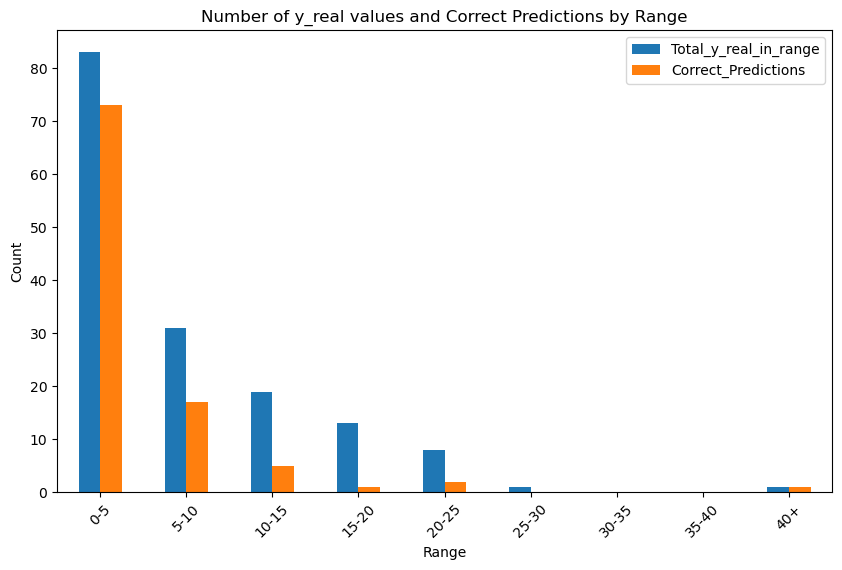

In [24]:
ranges = [ (0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df['y_real_in_range'] = results_df['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df['in_range'] = results_df.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df['y_real_in_range'].sum()
    
    correct_predictions = results_df['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total_y_real_in_range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of y_real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Confusion Matrix


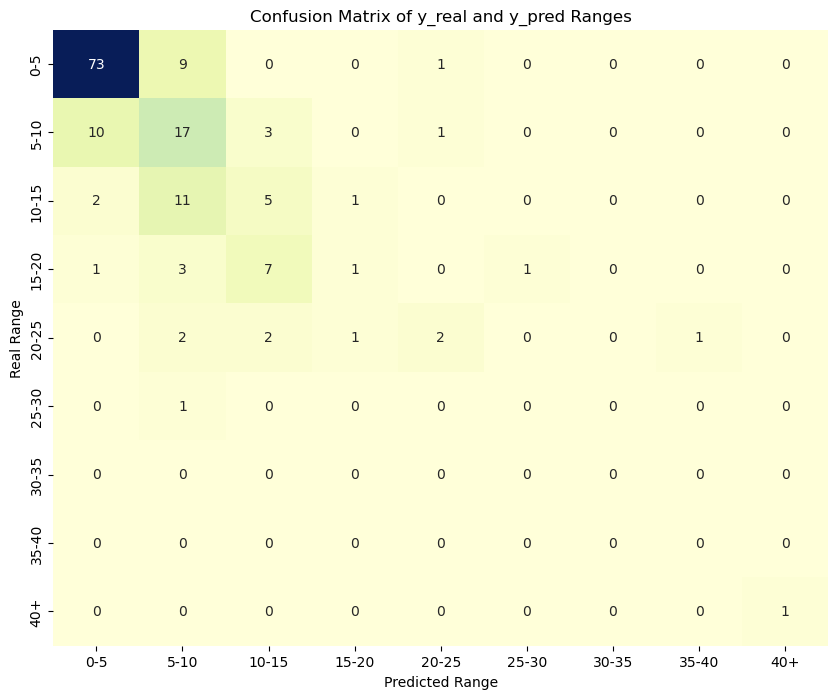

In [25]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df['y_real'] >= real_range_min) & (results_df['y_real'] <= real_range_max) &
                 (results_df['y_pred'] >= pred_range_min) & (results_df['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of y_real and y_pred Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [26]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
0-5: 87.95%
5-10: 54.84%
10-15: 26.32%
15-20: 7.69%
20-25: 25.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 100.00%


## Stratified Sampling 

Given the imbalance in the target variable (AAV), it is essential to ensure that both the training and test sets have a representative distribution of the target variable. This approach can help the model generalize better.

We can achieve a balanced split using stratified sampling. Stratified sampling will ensure that both the training and test sets have a similar distribution of the target variable.

If AAV is highly imbalanced with continuous values, stratified sampling based on the exact values might not always be feasible or meaningful. In such cases, we might need to create bins or categories for AAV before stratified sampling. For example:

Bin 1: AAV values below or equal to the 25th percentile
Bin 2: AAV values between the 25th and 50th percentiles
Bin 3: AAV values between the 50th and 75th percentiles
Bin 4: AAV values above the 75th percentile

In [27]:
y.describe()

count    508.000000
mean       7.165309
std        7.294814
min        0.715847
25%        1.783100
50%        4.512836
75%        9.942323
max       47.542409
Name: AAV, dtype: float64

In [28]:
q25 = df2['AAV'].quantile(0.25)
q50 = df2['AAV'].quantile(0.50)
q75 = df2['AAV'].quantile(0.75)

bins = [df2['AAV'].min(), q25, q50, q75, df2['AAV'].max()]
labels = [1, 2, 3, 4]
df2['AAV_binned'] = pd.cut(df2['AAV'], bins=bins, labels=labels, include_lowest=True)

y_binned = df2['AAV_binned']  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

print(f'Train set AAV distribution:\n{y_train.describe()}')
print(f'Test set AAV distribution:\n{y_test.describe()}')


X_train shape: (406, 65)
X_test shape: (102, 65)
y_train shape: (406,)
y_test shape: (102,)
Train set AAV distribution:
count    406.000000
mean       7.297195
std        7.585079
min        0.715847
25%        1.783100
50%        4.512836
75%        9.942323
max       47.542409
Name: AAV, dtype: float64
Test set AAV distribution:
count    102.000000
mean       6.640350
std        6.006141
min        0.715847
25%        1.816079
50%        4.616619
75%        9.790885
max       26.844273
Name: AAV, dtype: float64


C:\Users\mfran\AppData\Local\Temp\ipykernel_13500\3840007699.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, shade=True)


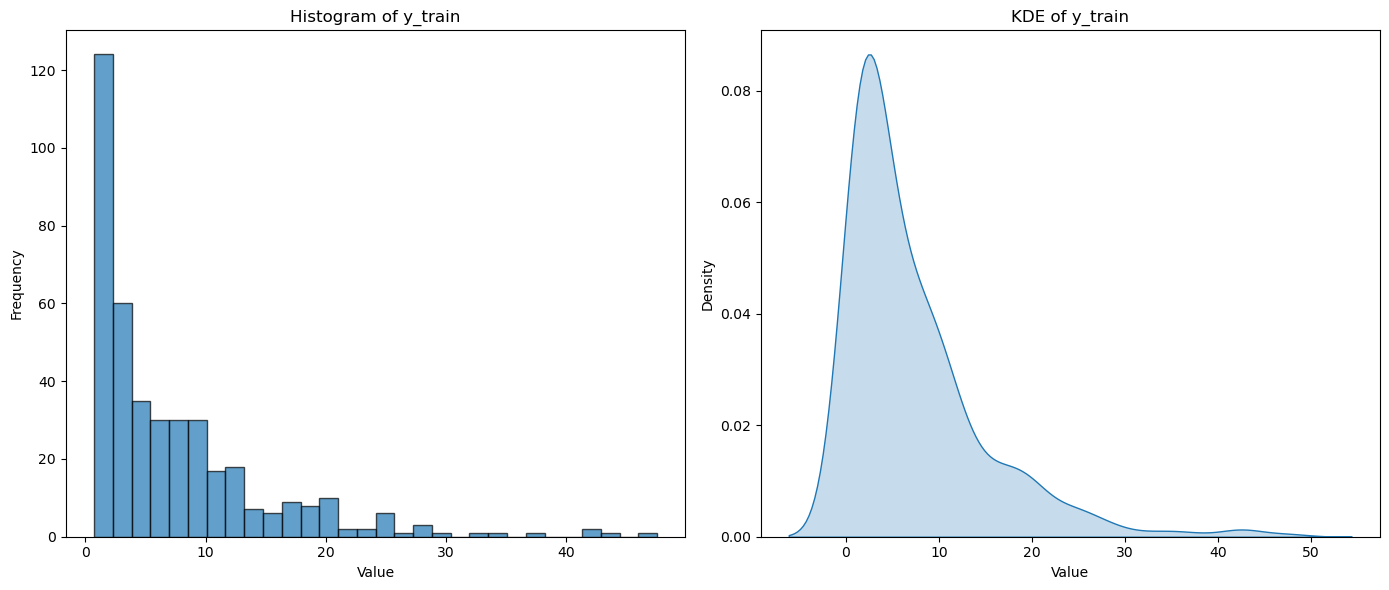

In [29]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_train')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_train, shade=True)
plt.title('KDE of y_train')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

C:\Users\mfran\AppData\Local\Temp\ipykernel_13500\893388450.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, shade=True)


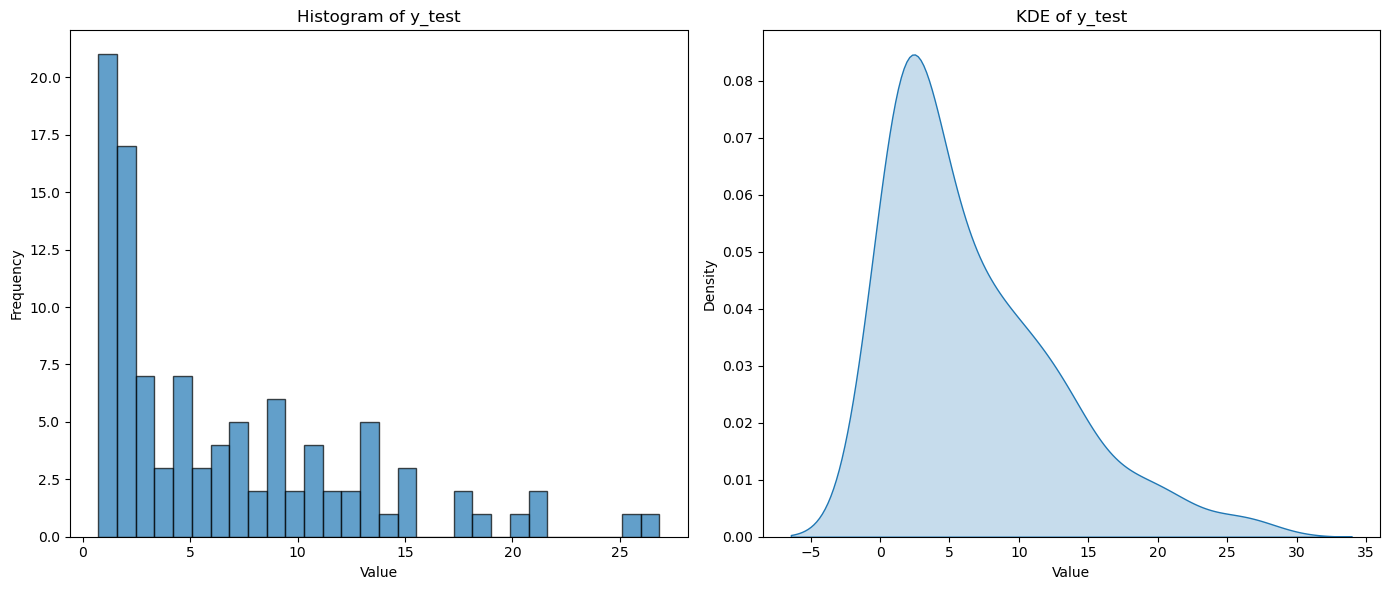

In [30]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of y_test')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(y_test, shade=True)
plt.title('KDE of y_test')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Linear Model (all variables, stratified sampling)

In [31]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [32]:
linear_model = LinearRegression()

y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
234,False,False,True,14,4,4,4.991598,1.386555,50,0,...,0.467670,3.671117,2.77,91.175364,0.794563,0.063238,2.742831,2.139540,0.603291,21.995191
98,False,True,False,15,8,10,3.350000,1.230000,25,24,...,-0.717636,4.432639,4.92,88.428472,3.971480,-1.051730,8.450975,12.549586,-4.098611,-48.498680
465,False,True,False,6,9,8,4.764706,1.307487,24,21,...,0.659078,3.993242,4.02,88.475727,3.911526,-0.211822,2.342204,9.790203,-7.447999,-317.991014
374,False,True,False,6,7,9,4.935484,1.303226,32,28,...,-2.144940,5.444745,6.12,87.432726,0.749912,-2.896780,13.076066,6.173654,6.902412,52.786609
347,False,False,True,11,5,2,2.548951,1.059441,62,0,...,-2.192904,4.439800,5.55,88.886497,1.485153,-0.800880,4.754933,5.765492,-1.010559,-21.252852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,False,True,False,20,7,14,6.482517,1.587413,28,28,...,1.111096,4.369841,4.28,90.001284,2.805918,-1.745914,2.070792,7.127041,-5.056249,-244.169843
78,False,False,True,8,6,4,4.464568,1.110236,38,0,...,0.073078,3.554938,5.11,91.737224,0.518303,-0.785634,1.100000,2.649414,-1.549414,-140.855811
395,False,True,True,11,5,10,5.720000,1.520000,28,22,...,-1.460748,5.340246,4.68,88.990998,0.652967,-3.517974,2.366619,3.220698,-0.854079,-36.088570
232,False,True,False,9,10,4,3.829327,1.182692,26,26,...,-0.572746,4.667681,6.57,89.047275,2.385181,-0.036096,13.714156,8.345774,5.368383,39.144826


### Evaluation Metrics (all variables stratified sampling)

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 4.721236034147105
MAPE: 0.513601004985501
R^2: 0.37597904244478486


Non stratified train splits: 
RMSE: 3.59318319106573
MAPE: 0.6487790486962602
R^2: 0.6195373883577687

Stratified train splits:
RMSE: 4.721236034147105
MAPE: 0.513601004985501
R^2: 0.37597904244478486

In [34]:
df2.drop(columns=['AAV_binned'], inplace=True)

## Ridge Regression (no stratified)

In [35]:
target = "AAV"
features = [col for col in df2.columns if col != target and col!= "Name"]
X, y = df2[features], df2[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (355, 65)
X_test shape: (153, 65)
y_train shape: (355,)
y_test shape: (153,)


In [36]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

ridge_y_pred = ridge_model.predict(X_test)

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,12,1,1,5.094341,1.556604,37,0,...,-0.406518,5.300887,6.09,85.801338,0.019265,-1.224556,1.479137,-3.466444,4.945581,334.355832
344,False,True,False,6,2,2,4.940000,1.260000,7,7,...,-0.581658,4.603308,5.03,89.231379,0.872343,-0.479032,4.160566,5.298909,-1.138342,-27.360273
47,False,False,True,9,7,2,3.281768,1.193370,61,0,...,-0.061196,5.461969,4.78,90.073819,-0.332473,-0.449046,4.500000,6.231154,-1.731154,-38.470085
67,False,False,True,7,2,2,3.375000,1.243421,51,0,...,-0.470414,3.680546,5.38,87.570701,-0.194070,-0.170446,6.000000,7.428335,-1.428335,-23.805580
363,False,True,True,10,7,9,3.570000,1.290000,36,30,...,-2.176972,5.571353,6.70,88.543539,1.432180,-2.293026,8.321133,8.957372,-0.636239,-7.646062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,True,False,12,2,2,3.160000,1.220000,9,8,...,1.490762,4.518217,4.09,85.657067,3.568354,1.046226,4.474045,8.695278,-4.221233,-94.349350
122,True,False,True,9,4,5,4.013514,1.601352,55,0,...,1.432300,4.192814,3.37,88.547549,0.899570,1.225240,0.745674,2.733978,-1.988304,-266.645074
260,False,True,False,9,10,11,3.810000,1.320000,33,33,...,0.837590,4.668484,4.48,88.653106,2.358952,2.477630,10.688667,7.263411,3.425256,32.045678
23,False,True,False,8,8,7,3.567198,1.202734,26,26,...,-0.017154,3.135680,3.46,88.450960,3.064483,0.838518,15.000000,13.603937,1.396063,9.307088


### Evaluation Metrics (Ridge Regression)

In [37]:
print(f"RMSE: {mean_squared_error(y_test, ridge_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, ridge_y_pred)}")
print(f"R^2: {r2_score(y_test, ridge_y_pred)}")

RMSE: 3.676014292773412
MAPE: 0.811093270805106
R^2: 0.7134522201776169


#### Correction for negative predictions

In [38]:
negative_values_exist = (results_df_ridge["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [39]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


y_train_log = np.log(y_train)


ridge_model = Ridge()
ridge_model.fit(X_train, y_train_log)


ridge_y_pred_log = ridge_model.predict(X_test)


ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test)) 

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")


results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

RMSE: 4.616854985570483
MAPE: 0.47359653881893243
R^2: 0.5480034368123416


,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,12,1,1,5.094341,1.556604,37,0,...,-0.406518,5.300887,6.09,85.801338,0.019265,-1.224556,1.479137,0.551656,0.927481,62.704230
344,False,True,False,6,2,2,4.940000,1.260000,7,7,...,-0.581658,4.603308,5.03,89.231379,0.872343,-0.479032,4.160566,3.564029,0.596538,14.337898
47,False,False,True,9,7,2,3.281768,1.193370,61,0,...,-0.061196,5.461969,4.78,90.073819,-0.332473,-0.449046,4.500000,3.126671,1.373329,30.518427
67,False,False,True,7,2,2,3.375000,1.243421,51,0,...,-0.470414,3.680546,5.38,87.570701,-0.194070,-0.170446,6.000000,4.144830,1.855170,30.919504
363,False,True,True,10,7,9,3.570000,1.290000,36,30,...,-2.176972,5.571353,6.70,88.543539,1.432180,-2.293026,8.321133,6.758769,1.562364,18.775853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,True,False,12,2,2,3.160000,1.220000,9,8,...,1.490762,4.518217,4.09,85.657067,3.568354,1.046226,4.474045,6.241979,-1.767934,-39.515325
122,True,False,True,9,4,5,4.013514,1.601352,55,0,...,1.432300,4.192814,3.37,88.547549,0.899570,1.225240,0.745674,2.297637,-1.551962,-208.128740
260,False,True,False,9,10,11,3.810000,1.320000,33,33,...,0.837590,4.668484,4.48,88.653106,2.358952,2.477630,10.688667,6.180489,4.508178,42.177175
23,False,True,False,8,8,7,3.567198,1.202734,26,26,...,-0.017154,3.135680,3.46,88.450960,3.064483,0.838518,15.000000,7.613042,7.386958,49.246387


#### Testing 0-5 range values

In [40]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()

correct_predictions = results_df_ridge['in_range'].sum()

print(f'Number of y_real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of y_real values in the range 0-5: 83
Number of correct predictions in the range 0-5: 73


   Range  Total_y_real_in_range  Correct_Predictions
0    0-5                     83                   73
1   5-10                     31                   17
2  10-15                     19                    5
3  15-20                     13                    2
4  20-25                      8                    2
5  25-30                      1                    0
6  30-35                      0                    0
7  35-40                      0                    0
8    40+                      1                    1


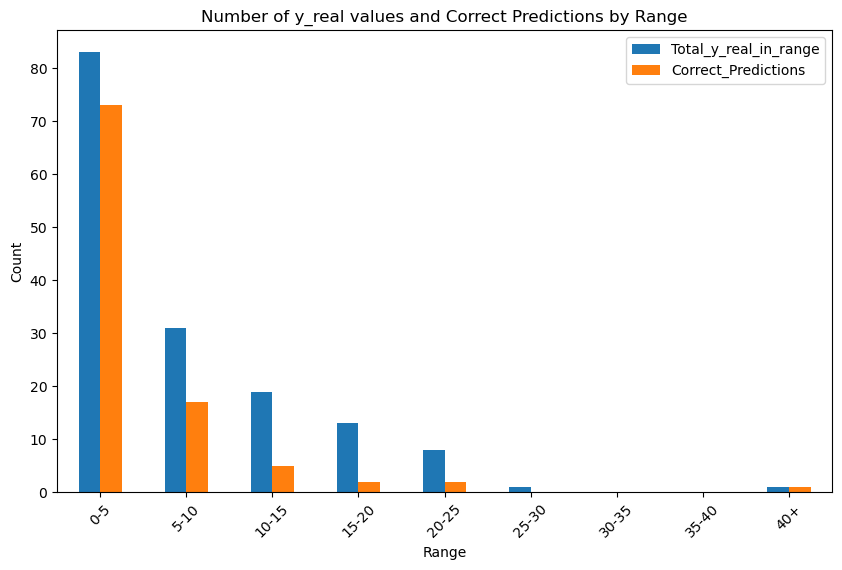

In [41]:
def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df_ridge['y_real_in_range'] = results_df_ridge['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df_ridge['in_range'] = results_df_ridge.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_ridge['y_real_in_range'].sum()
    
    correct_predictions = results_df_ridge['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total_y_real_in_range': total_y_real_in_range,
        'Correct_Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of y_real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

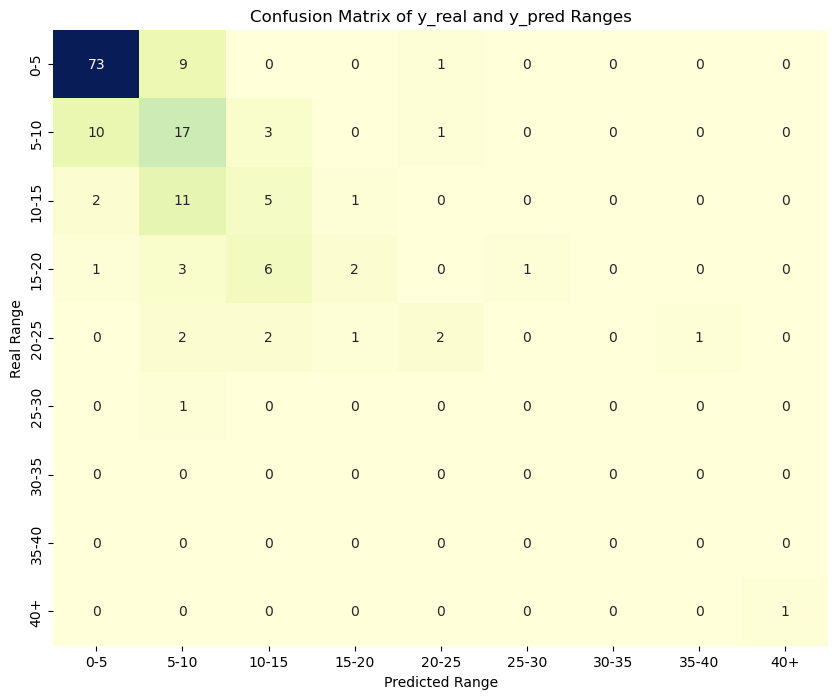

In [42]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df_ridge['y_real'] >= real_range_min) & (results_df_ridge['y_real'] <= real_range_max) &
                 (results_df_ridge['y_pred'] >= pred_range_min) & (results_df_ridge['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of y_real and y_pred Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [43]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
0-5: 87.95%
5-10: 54.84%
10-15: 26.32%
15-20: 15.38%
20-25: 25.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 100.00%


## XGBoost Regression

In [44]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

results_df_xgb = X_test.copy()
results_df_xgb["y_real"] = y_test
results_df_xgb["y_pred"] = xgb_y_pred
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


results_df_xgb

,minor_league,SP,RP,Yrs,W,L,ERA,WHIP,G,GS,...,WPA_2,SIERA_2,xERA_2,EV_2,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,12,1,1,5.094341,1.556604,37,0,...,-0.406518,5.300887,6.09,85.801338,0.019265,-1.224556,1.479137,0.502871,0.976266,66.002409
344,False,True,False,6,2,2,4.940000,1.260000,7,7,...,-0.581658,4.603308,5.03,89.231379,0.872343,-0.479032,4.160566,5.596687,-1.436120,-34.517424
47,False,False,True,9,7,2,3.281768,1.193370,61,0,...,-0.061196,5.461969,4.78,90.073819,-0.332473,-0.449046,4.500000,3.124447,1.375553,30.567847
67,False,False,True,7,2,2,3.375000,1.243421,51,0,...,-0.470414,3.680546,5.38,87.570701,-0.194070,-0.170446,6.000000,5.719205,0.280795,4.679910
363,False,True,True,10,7,9,3.570000,1.290000,36,30,...,-2.176972,5.571353,6.70,88.543539,1.432180,-2.293026,8.321133,12.650150,-4.329017,-52.024375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,True,False,12,2,2,3.160000,1.220000,9,8,...,1.490762,4.518217,4.09,85.657067,3.568354,1.046226,4.474045,3.513815,0.960230,21.462233
122,True,False,True,9,4,5,4.013514,1.601352,55,0,...,1.432300,4.192814,3.37,88.547549,0.899570,1.225240,0.745674,2.432479,-1.686805,-226.212036
260,False,True,False,9,10,11,3.810000,1.320000,33,33,...,0.837590,4.668484,4.48,88.653106,2.358952,2.477630,10.688667,13.377201,-2.688534,-25.153127
23,False,True,False,8,8,7,3.567198,1.202734,26,26,...,-0.017154,3.135680,3.46,88.450960,3.064483,0.838518,15.000000,12.619287,2.380713,15.871417


### Evaluation Metrics (XGBoost Regression)

In [45]:
print(f"RMSE: {mean_squared_error(y_test, xgb_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_y_pred)}")
print(f"R^2: {r2_score(y_test, xgb_y_pred)}")

RMSE: 3.8006633797811604
MAPE: 0.6126600908496226
R^2: 0.6936897865074547


In [46]:
negative_values_exist = (results_df_xgb["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.


#### Testing 0-5 range values

In [47]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()

correct_predictions = results_df_xgb['in_range'].sum()

print(f'Number of y_real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of y_real values in the range 0-5: 83
Number of correct predictions in the range 0-5: 62


#### All ranges visualized with a bar plot

   Range  Total Real in range  Correct Predictions
0    0-5                   83                   62
1   5-10                   31                   15
2  10-15                   19                    9
3  15-20                   13                    3
4  20-25                    8                    2
5  25-30                    1                    0
6  30-35                    0                    0
7  35-40                    0                    0
8    40+                    1                    0


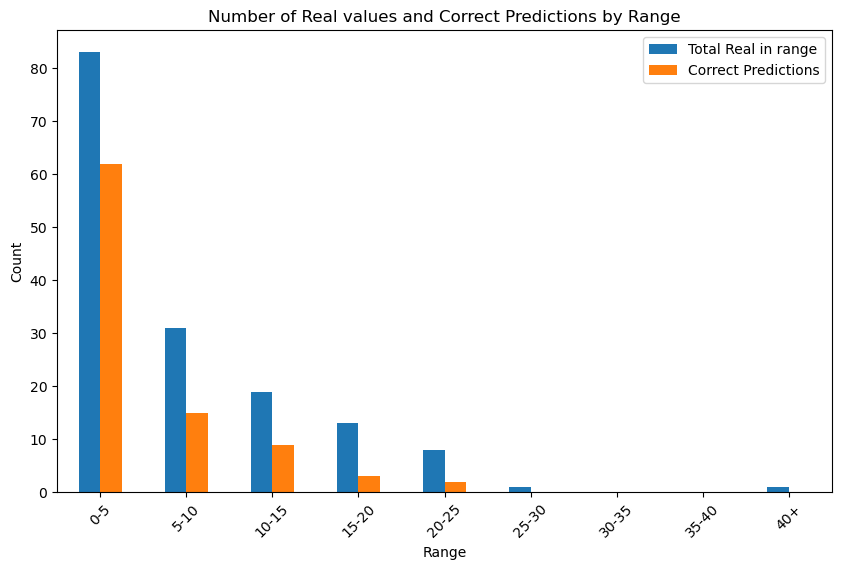

In [48]:
def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_list = []

for range_min, range_max in ranges:
    results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)
    results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()
    
    correct_predictions = results_df_xgb['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in range': total_y_real_in_range,
        'Correct Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

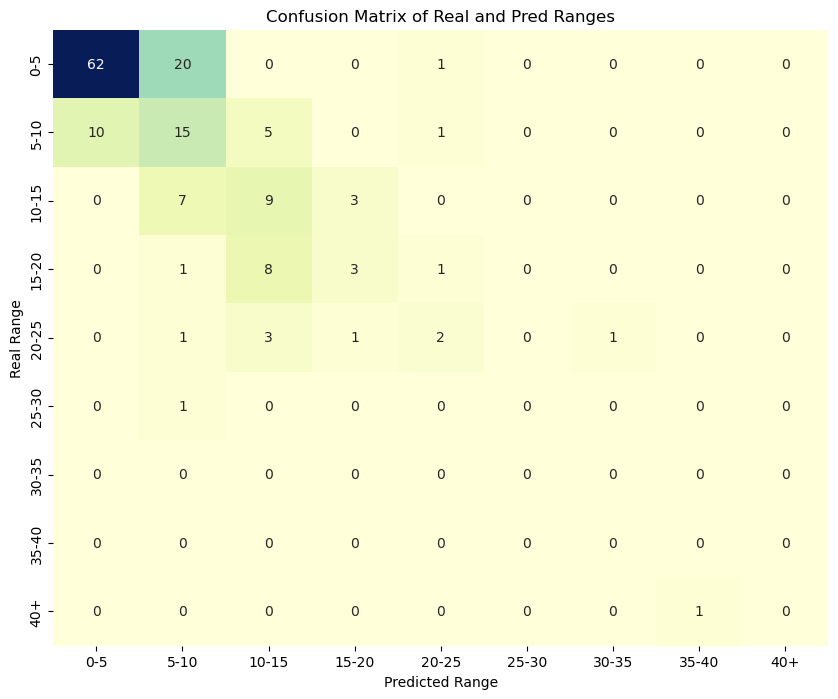

In [49]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df_xgb['y_real'] >= real_range_min) & (results_df_xgb['y_real'] <= real_range_max) &
                 (results_df_xgb['y_pred'] >= pred_range_min) & (results_df_xgb['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of Real and Pred Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [50]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
0-5: 74.70%
5-10: 48.39%
10-15: 47.37%
15-20: 23.08%
20-25: 25.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 0.00%


#### W_L_Ratio 

To this model I want to add a W_L ratio and see its correlation with AAV

In [51]:
df2['Acc_W'] = df2['W'] + df2['W_2']
df2['Acc_L'] = df2['L'] + df2['L_2']

df2['W_L_Ratio'] = df2.apply(lambda row: row['Acc_W'] / row['Acc_L'] if row['Acc_L'] != 0 else float('inf') if row['Acc_W'] != 0 else 0, axis=1)
df2[['Acc_W', 'Acc_L', 'W_L_Ratio']].head()

,Acc_W,Acc_L,W_L_Ratio
0,25,14,1.785714
1,16,13,1.230769
2,18,5,3.600000
3,23,22,1.045455
4,25,8,3.125000


In [52]:
##filtered_df = df2[(df2['W_2'] == 0) & (df2['L_2'] == 0)]
filtered_df = df2[(df2['W_L_Ratio'] > 20) ]

filtered_df[['W', 'W_2', 'L', 'L_2', 'Acc_W', 'Acc_L', 'W_L_Ratio']]

,W,W_2,L,L_2,Acc_W,Acc_L,W_L_Ratio
162,1,0,0,0,1,0,inf
192,6,0,0,0,6,0,inf
239,1,3,0,0,4,0,inf
315,4,0,0,0,4,0,inf
417,6,1,0,0,7,0,inf
494,1,2,0,0,3,0,inf


In [53]:
df2['Acc_L'] = df2['Acc_L'].apply(lambda x: x + 1 if x == 0 else x)

df2['W_L_Ratio'] = df2['Acc_W'] / df2['Acc_L']

print(df2[['W', 'W_2', 'L', 'L_2', 'Acc_W', 'Acc_L', 'W_L_Ratio']].head())

correlation = df2['W_L_Ratio'].corr(df2['AAV'])
print(f'Correlation between W_L_Ratio and AAV: {correlation}')

    W  W_2  L  L_2  Acc_W  Acc_L  W_L_Ratio
0  10   15  5    9     25     14   1.785714
1   8    8  8    5     16     13   1.230769
2   5   13  1    4     18      5   3.600000
3  12   11  9   13     23     22   1.045455
4  13   12  5    3     25      8   3.125000
Correlation between W_L_Ratio and AAV: 0.154203420732014


In [54]:
df2["W_L_Ratio"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 508 entries, 0 to 507
Series name: W_L_Ratio
Non-Null Count  Dtype  
--------------  -----  
508 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


#### Checking multicolinearity between the new variables created

In [55]:
X = df2[['W_L_Ratio','L','W']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

     feature       VIF
0      const  5.663881
1  W_L_Ratio  1.344429
2          L  1.976279
3          W  1.864976


There doesn't seem to be any correlation. For now, this means we will keep them. 

#### Checking multicolinearity between the different variables for time played

It is done taking into account the clustered correlation matrix done in the first steps.

In [56]:
X = df2[['GS', 'IP', 'QS','Acc_SO','SO','W']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  feature        VIF
0   const   8.447159
1      GS   9.451758
2      IP  11.129310
3      QS   8.017818
4  Acc_SO   4.266094
5      SO   9.591005
6       W   4.366932


In [57]:
X = df2[['IP', 'QS']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  feature       VIF
0   const  5.359859
1      IP  4.645125
2      QS  4.645125


In [58]:
X = df2[['W', 'L']]

X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

  feature       VIF
0   const  3.044036
1       W  1.513494
2       L  1.513494


### Selected Variables 

In [59]:
slc_columns=['Name','AAV','QS', 'HLD_2','SO','Acc_WAR','Acc_WPA','BB/9','ERA','FIP','K/9','L','RP','SIERA','SP','W','WHIP','minor_league','xERA','xFIP']
columns_to_drop = [col for col in df2.columns if col not in slc_columns]
df2.drop(columns=columns_to_drop, inplace=True)

In [60]:
df2.head()

,Name,AAV,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,BB/9,HLD_2,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA
0,Shohei Ohtani,34.877193,False,True,False,10,5,3.136364,1.060606,12,167,11.386364,3.750000,0,3.997465,3.577480,3.663228,3.82,7.966784,5.364157
1,Sonny Gray,25.000000,False,True,False,8,8,1.790000,1.150000,17,183,8.950000,2.690000,0,2.825693,3.644259,3.949935,3.66,7.645342,3.818644
2,Brandon Woodruff,8.750000,False,True,False,5,1,2.283582,0.820896,7,74,9.940299,2.014925,0,3.598324,3.628791,3.445838,2.82,5.001775,3.346239
3,Aaron Nola,24.571429,False,True,False,12,9,4.460000,1.150000,15,202,9.390000,2.090000,0,4.029567,3.631652,3.751155,3.71,10.192750,2.951880
4,Clayton Kershaw,5.000000,False,True,False,13,5,2.460000,1.060000,11,137,9.360000,2.730000,0,4.029724,3.572727,3.817126,3.77,6.191165,4.462551


In [61]:
target = "AAV"
feat = [col for col in df2.columns if col != target and col!= "Name"]
X, y = df2[feat], df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (355, 18)
X_test shape: (153, 18)
y_train shape: (355,)
y_test shape: (153,)


In [62]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [63]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,1,1,5.094341,1.556604,0,23,5.858492,...,4.685942,5.580392,5.049976,6.53,0.019265,-1.224556,1.479137,-2.133448,3.612585,244.236012
344,False,True,False,2,2,4.940000,1.260000,0,33,9.580000,...,3.353980,3.640975,3.754773,5.51,0.872343,-0.479032,4.160566,4.873440,-0.712874,-17.134053
47,False,False,True,7,2,3.281768,1.193370,0,80,11.933703,...,4.630731,4.335722,3.903878,4.51,-0.332473,-0.449046,4.500000,5.214999,-0.714999,-15.888856
67,False,False,True,2,2,3.375000,1.243421,0,64,11.368422,...,4.202409,3.259263,3.337010,3.71,-0.194070,-0.170446,6.000000,5.618510,0.381490,6.358172
363,False,True,True,7,9,3.570000,1.290000,11,169,8.880000,...,3.872494,4.069622,4.195858,4.12,1.432180,-2.293026,8.321133,8.257851,0.063282,0.760497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,True,False,2,2,3.160000,1.220000,2,28,6.810000,...,3.950269,4.416594,4.478685,3.86,3.568354,1.046226,4.474045,9.816545,-5.342499,-119.410930
122,True,False,True,4,5,4.013514,1.601352,0,52,9.486488,...,4.044864,4.114194,3.909213,3.72,0.899570,1.225240,0.745674,3.583800,-2.838126,-380.612009
260,False,True,False,10,11,3.810000,1.320000,15,162,8.350000,...,4.662483,5.257240,5.109264,4.76,2.358952,2.477630,10.688667,10.914862,-0.226195,-2.116212
23,False,True,False,8,7,3.567198,1.202734,17,140,8.610479,...,3.829072,3.756835,3.970280,4.42,3.064483,0.838518,15.000000,11.721196,3.278804,21.858690


In [64]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 3.7223975039321298
MAPE: 0.8202722966711408
R^2: 0.7061753943882565


In [65]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [66]:
linear_model = LinearRegression()

y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,1,1,5.094341,1.556604,0,23,5.858492,...,4.685942,5.580392,5.049976,6.53,0.019265,-1.224556,1.479137,0.668720,0.810417,54.789857
344,False,True,False,2,2,4.940000,1.260000,0,33,9.580000,...,3.353980,3.640975,3.754773,5.51,0.872343,-0.479032,4.160566,4.266652,-0.106085,-2.549777
47,False,False,True,7,2,3.281768,1.193370,0,80,11.933703,...,4.630731,4.335722,3.903878,4.51,-0.332473,-0.449046,4.500000,4.175233,0.324767,7.217039
67,False,False,True,2,2,3.375000,1.243421,0,64,11.368422,...,4.202409,3.259263,3.337010,3.71,-0.194070,-0.170446,6.000000,3.981950,2.018050,33.634171
363,False,True,True,7,9,3.570000,1.290000,11,169,8.880000,...,3.872494,4.069622,4.195858,4.12,1.432180,-2.293026,8.321133,5.357089,2.964044,35.620675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,True,False,2,2,3.160000,1.220000,2,28,6.810000,...,3.950269,4.416594,4.478685,3.86,3.568354,1.046226,4.474045,6.773103,-2.299058,-51.386548
122,True,False,True,4,5,4.013514,1.601352,0,52,9.486488,...,4.044864,4.114194,3.909213,3.72,0.899570,1.225240,0.745674,2.415899,-1.670224,-223.988492
260,False,True,False,10,11,3.810000,1.320000,15,162,8.350000,...,4.662483,5.257240,5.109264,4.76,2.358952,2.477630,10.688667,9.138921,1.549746,14.498967
23,False,True,False,8,7,3.567198,1.202734,17,140,8.610479,...,3.829072,3.756835,3.970280,4.42,3.064483,0.838518,15.000000,7.658834,7.341166,48.941105


In [67]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 4.656704915463265
MAPE: 0.5180444078606614
R^2: 0.5401670347809937


## Ridge Regression

In [68]:
from sklearn.linear_model import Ridge

ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

ridge_y_pred = ridge_model.predict(X_test)

results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,1,1,5.094341,1.556604,0,23,5.858492,...,4.685942,5.580392,5.049976,6.53,0.019265,-1.224556,1.479137,-2.124730,3.603867,243.646622
344,False,True,False,2,2,4.940000,1.260000,0,33,9.580000,...,3.353980,3.640975,3.754773,5.51,0.872343,-0.479032,4.160566,4.834968,-0.674401,-16.209359
47,False,False,True,7,2,3.281768,1.193370,0,80,11.933703,...,4.630731,4.335722,3.903878,4.51,-0.332473,-0.449046,4.500000,5.185793,-0.685793,-15.239845
67,False,False,True,2,2,3.375000,1.243421,0,64,11.368422,...,4.202409,3.259263,3.337010,3.71,-0.194070,-0.170446,6.000000,5.636679,0.363321,6.055351
363,False,True,True,7,9,3.570000,1.290000,11,169,8.880000,...,3.872494,4.069622,4.195858,4.12,1.432180,-2.293026,8.321133,8.297758,0.023375,0.280915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,True,False,2,2,3.160000,1.220000,2,28,6.810000,...,3.950269,4.416594,4.478685,3.86,3.568354,1.046226,4.474045,9.761500,-5.287454,-118.180607
122,True,False,True,4,5,4.013514,1.601352,0,52,9.486488,...,4.044864,4.114194,3.909213,3.72,0.899570,1.225240,0.745674,3.635951,-2.890276,-387.605761
260,False,True,False,10,11,3.810000,1.320000,15,162,8.350000,...,4.662483,5.257240,5.109264,4.76,2.358952,2.477630,10.688667,10.947226,-0.258559,-2.418998
23,False,True,False,8,7,3.567198,1.202734,17,140,8.610479,...,3.829072,3.756835,3.970280,4.42,3.064483,0.838518,15.000000,11.746905,3.253095,21.687301


In [69]:
print(f"RMSE: {mean_squared_error(y_test, ridge_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, ridge_y_pred)}")
print(f"R^2: {r2_score(y_test, ridge_y_pred)}")

RMSE: 3.7228166595537755
MAPE: 0.8173974073278081
R^2: 0.7061092192045881


In [70]:
negative_values_exist = (results_df_ridge["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are negative values in the 'y_pred' column.


In [71]:
y_train_log = np.log(y_train)


ridge_model = Ridge()
ridge_model.fit(X_train, y_train_log)


ridge_y_pred_log = ridge_model.predict(X_test)


ridge_y_pred = np.exp(ridge_y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))
r2 = r2_score(y_test, ridge_y_pred)
mape = np.mean(np.abs((y_test - ridge_y_pred) / y_test)) 

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R^2: {r2}")


results_df_ridge = X_test.copy()
results_df_ridge["y_real"] = y_test
results_df_ridge["y_pred"] = ridge_y_pred
results_df_ridge["err"] = results_df_ridge["y_real"] - results_df_ridge["y_pred"]
results_df_ridge["%_err"] = results_df_ridge["err"] / results_df_ridge["y_real"] * 100

results_df_ridge

RMSE: 4.660491328475007
MAPE: 0.5185199920055269
R^2: 0.5394189412623671


,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,1,1,5.094341,1.556604,0,23,5.858492,...,4.685942,5.580392,5.049976,6.53,0.019265,-1.224556,1.479137,0.677490,0.801647,54.196913
344,False,True,False,2,2,4.940000,1.260000,0,33,9.580000,...,3.353980,3.640975,3.754773,5.51,0.872343,-0.479032,4.160566,4.243952,-0.083386,-2.004198
47,False,False,True,7,2,3.281768,1.193370,0,80,11.933703,...,4.630731,4.335722,3.903878,4.51,-0.332473,-0.449046,4.500000,4.153334,0.346666,7.703683
67,False,False,True,2,2,3.375000,1.243421,0,64,11.368422,...,4.202409,3.259263,3.337010,3.71,-0.194070,-0.170446,6.000000,3.971747,2.028253,33.804210
363,False,True,True,7,9,3.570000,1.290000,11,169,8.880000,...,3.872494,4.069622,4.195858,4.12,1.432180,-2.293026,8.321133,5.380750,2.940383,35.336334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,True,False,2,2,3.160000,1.220000,2,28,6.810000,...,3.950269,4.416594,4.478685,3.86,3.568354,1.046226,4.474045,6.702152,-2.228106,-49.800712
122,True,False,True,4,5,4.013514,1.601352,0,52,9.486488,...,4.044864,4.114194,3.909213,3.72,0.899570,1.225240,0.745674,2.449796,-1.704122,-228.534319
260,False,True,False,10,11,3.810000,1.320000,15,162,8.350000,...,4.662483,5.257240,5.109264,4.76,2.358952,2.477630,10.688667,9.144876,1.543791,14.443251
23,False,True,False,8,7,3.567198,1.202734,17,140,8.610479,...,3.829072,3.756835,3.970280,4.42,3.064483,0.838518,15.000000,7.664771,7.335229,48.901528


In [72]:
print(f"RMSE: {mean_squared_error(y_test, ridge_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, ridge_y_pred)}")
print(f"R^2: {r2_score(y_test, ridge_y_pred)}")

RMSE: 4.660491328475007
MAPE: 0.5185199920055269
R^2: 0.5394189412623671


## XGBoost Regression

In [73]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

results_df_xgb = X_test.copy()
results_df_xgb["y_real"] = y_test
results_df_xgb["y_pred"] = xgb_y_pred
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


results_df_xgb

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,FIP,xFIP,SIERA,xERA,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err
444,True,False,True,1,1,5.094341,1.556604,0,23,5.858492,...,4.685942,5.580392,5.049976,6.53,0.019265,-1.224556,1.479137,1.071125,0.408012,27.584481
344,False,True,False,2,2,4.940000,1.260000,0,33,9.580000,...,3.353980,3.640975,3.754773,5.51,0.872343,-0.479032,4.160566,3.436731,0.723836,17.397525
47,False,False,True,7,2,3.281768,1.193370,0,80,11.933703,...,4.630731,4.335722,3.903878,4.51,-0.332473,-0.449046,4.500000,3.841745,0.658255,14.627896
67,False,False,True,2,2,3.375000,1.243421,0,64,11.368422,...,4.202409,3.259263,3.337010,3.71,-0.194070,-0.170446,6.000000,5.008007,0.991993,16.533224
363,False,True,True,7,9,3.570000,1.290000,11,169,8.880000,...,3.872494,4.069622,4.195858,4.12,1.432180,-2.293026,8.321133,10.577106,-2.255973,-27.111364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,True,False,2,2,3.160000,1.220000,2,28,6.810000,...,3.950269,4.416594,4.478685,3.86,3.568354,1.046226,4.474045,6.480909,-2.006863,-44.855677
122,True,False,True,4,5,4.013514,1.601352,0,52,9.486488,...,4.044864,4.114194,3.909213,3.72,0.899570,1.225240,0.745674,1.138619,-0.392945,-52.696611
260,False,True,False,10,11,3.810000,1.320000,15,162,8.350000,...,4.662483,5.257240,5.109264,4.76,2.358952,2.477630,10.688667,14.600745,-3.912078,-36.600243
23,False,True,False,8,7,3.567198,1.202734,17,140,8.610479,...,3.829072,3.756835,3.970280,4.42,3.064483,0.838518,15.000000,14.720179,0.279821,1.865476


In [74]:
print(f"RMSE: {mean_squared_error(y_test, xgb_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_y_pred)}")
print(f"R^2: {r2_score(y_test, xgb_y_pred)}")

RMSE: 3.7440745666481003
MAPE: 0.589935267881798
R^2: 0.7027433053649531


In [75]:
negative_values_exist = (results_df_xgb["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

There are no negative values in the 'y_pred' column.


#### Testing 0-5 range values

In [76]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()

correct_predictions = results_df_xgb['in_range'].sum()

print(f'Number of Real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

Number of Real values in the range 0-5: 83
Number of correct predictions in the range 0-5: 65


   Range  Total Real in range  Correct Predictions
0    0-5                   82                   65
1   5-10                   31                   14
2  10-15                   18                    8
3  15-20                   12                    3
4  20-25                    8                    2
5  25-30                    1                    0
6  30-35                    0                    0
7  35-40                    0                    0
8    40+                    1                    0


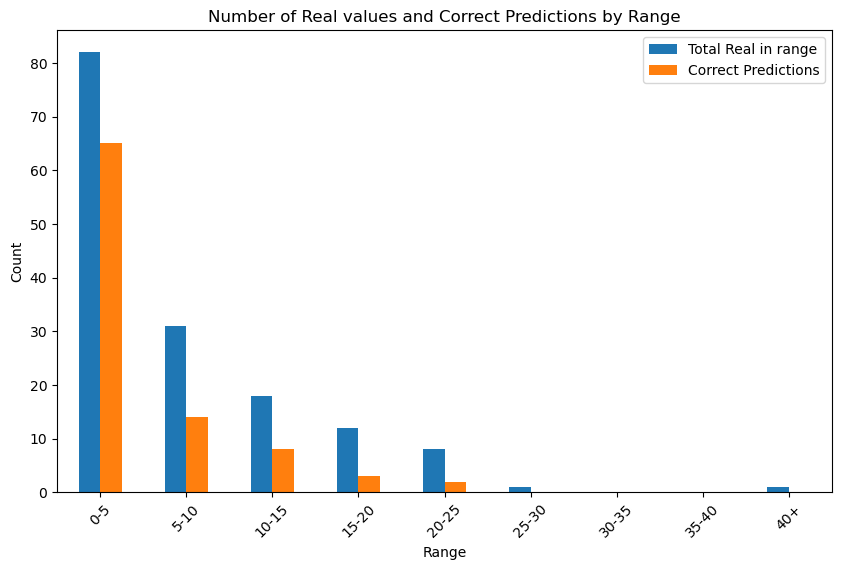

In [77]:
ranges = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    if range_max == float('inf'):
        return range_min <= y_real and range_min <= y_pred
    else:
        return range_min <= y_real < range_max and range_min <= y_pred < range_max

results_list = []

for range_min, range_max in ranges:
    results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y < range_max if range_max != float('inf') else range_min <= y)
    results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()
    correct_predictions = results_df_xgb['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in range': total_y_real_in_range,
        'Correct Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

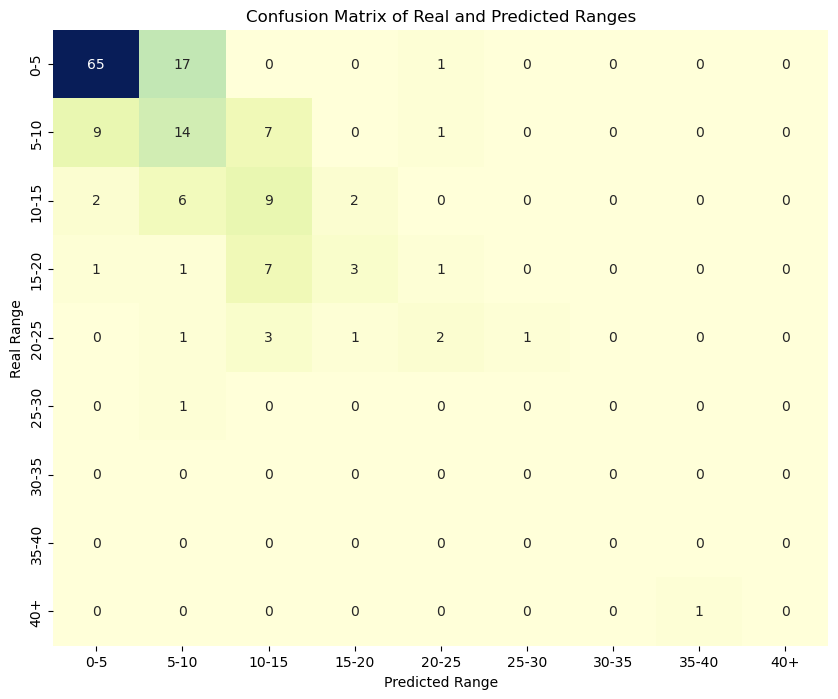

In [78]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df_xgb['y_real'] >= real_range_min) & (results_df_xgb['y_real'] <= real_range_max) &
                 (results_df_xgb['y_pred'] >= pred_range_min) & (results_df_xgb['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of Real and Predicted Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [79]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

Percentage of Correct Predictions per Bin:
0-5: 78.31%
5-10: 45.16%
10-15: 47.37%
15-20: 23.08%
20-25: 25.00%
25-30: 0.00%
30-35: 0.00%
35-40: 0.00%
40+: 0.00%


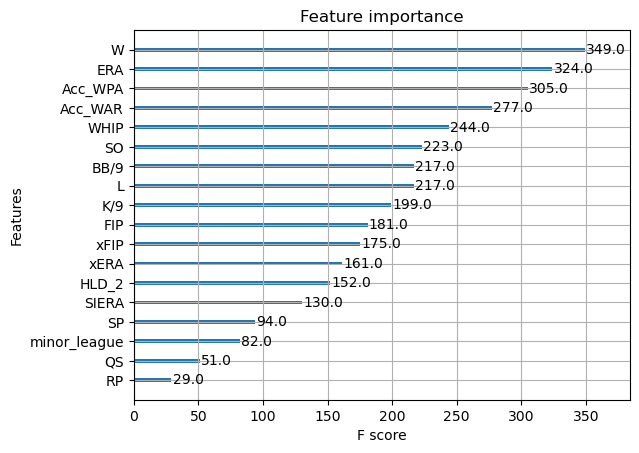

In [80]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()


### TESTING BEST MODEL: 

#### XGBOOST BEST 5 PREDICTIONS

In [81]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          508 non-null    object 
 1   AAV           508 non-null    float64
 2   minor_league  508 non-null    bool   
 3   SP            508 non-null    bool   
 4   RP            508 non-null    bool   
 5   W             508 non-null    int64  
 6   L             508 non-null    int64  
 7   ERA           508 non-null    float64
 8   WHIP          508 non-null    float64
 9   QS            508 non-null    int64  
 10  SO            508 non-null    int64  
 11  K/9           508 non-null    float64
 12  BB/9          508 non-null    float64
 13  HLD_2         508 non-null    int64  
 14  FIP           508 non-null    float64
 15  xFIP          508 non-null    float64
 16  SIERA         508 non-null    float64
 17  xERA          508 non-null    float64
 18  Acc_WAR       508 non-null    

In [82]:
results_df_xgb_with_names = results_df_xgb.merge(df2[['Name']], left_index=True, right_index=True)

results_df_xgb_with_names['absolute_difference'] = abs(results_df_xgb_with_names['y_real'] - results_df_xgb_with_names['y_pred'])

sorted_df = results_df_xgb_with_names.sort_values(by='absolute_difference')

closest_5_predictions = sorted_df.head(5)

closest_5_predictions

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err,y_real_in_range,in_range,Name,absolute_difference
493,True,True,True,3,5,5.710000,1.530000,2,49,6.360000,...,1.600585,-0.939946,1.405323,1.407365,-0.002042,-0.145327,False,False,Tommy Milone,0.002042
420,False,False,True,2,3,3.140000,1.200000,0,74,8.290000,...,0.140207,2.489512,2.662446,2.660035,0.002411,0.090568,False,False,Craig Stammen,0.002411
426,True,False,True,1,1,4.350000,1.550000,0,33,7.190000,...,0.686439,0.403636,1.183310,1.180490,0.002820,0.238294,False,False,Blainer Boyer,0.002820
377,True,False,True,3,1,4.532847,1.642336,0,41,8.080293,...,-0.146331,-1.736304,1.069860,1.038973,0.030887,2.887000,False,False,Jake Petricka,0.030887
162,True,False,True,1,0,6.084508,1.521127,0,17,6.464789,...,0.116393,0.340404,0.715847,0.677747,0.038100,5.322385,False,False,Adonis Medina,0.038100


#### XGBOOST WORST 5 PREDICTIONS

In [83]:
sorted_df_desc = results_df_xgb_with_names.sort_values(by='absolute_difference', ascending=False)
furthest_5_predictions = sorted_df_desc.head(5)
furthest_5_predictions

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err,y_real_in_range,in_range,Name,absolute_difference
4,False,True,False,13,5,2.460000,1.060000,11,137,9.360000,...,6.191165,4.462551,5.000000,23.969025,-18.969025,-379.380493,False,False,Clayton Kershaw,18.969025
258,False,True,False,8,8,3.750000,1.370000,12,91,7.270000,...,3.986630,1.778826,25.189625,9.514602,15.675024,62.228094,False,False,Dallas Keuchel,15.675024
17,False,False,True,2,0,5.400000,1.000000,0,3,5.400000,...,1.554939,2.347752,18.000000,3.361445,14.638555,81.325306,False,False,Liam Hendriks,14.638555
334,False,True,False,7,3,1.967611,1.008097,9,89,9.728744,...,2.513650,1.747212,21.278326,9.788774,11.489552,53.996505,False,False,Hyun Jin Ryu,11.489552
351,False,True,False,6,7,3.810811,1.126126,8,101,8.189189,...,4.371201,0.520156,20.208466,10.261480,9.946985,49.221873,False,False,Nathan Eovaldi,9.946985


#### 5 Players the model expected to receive less money

In [84]:
exp_less = results_df_xgb_with_names.sort_values(by='err', ascending=False)

exp_less.head(5)

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err,y_real_in_range,in_range,Name,absolute_difference
258,False,True,False,8,8,3.750000,1.370000,12,91,7.270000,...,3.986630,1.778826,25.189625,9.514602,15.675024,62.228094,False,False,Dallas Keuchel,15.675024
17,False,False,True,2,0,5.400000,1.000000,0,3,5.400000,...,1.554939,2.347752,18.000000,3.361445,14.638555,81.325306,False,False,Liam Hendriks,14.638555
334,False,True,False,7,3,1.967611,1.008097,9,89,9.728744,...,2.513650,1.747212,21.278326,9.788774,11.489552,53.996505,False,False,Hyun Jin Ryu,11.489552
351,False,True,False,6,7,3.810811,1.126126,8,101,8.189189,...,4.371201,0.520156,20.208466,10.261480,9.946985,49.221873,False,False,Nathan Eovaldi,9.946985
453,False,False,True,2,2,1.640000,0.900000,0,65,8.200000,...,3.250921,9.016062,18.152083,9.621531,8.530551,46.994890,False,False,Mark Melancon,8.530551


#### 5 Players the model expected to receive more money


In [85]:
exp_more = results_df_xgb_with_names.sort_values(by='err', ascending=True)

exp_more.head(5)

,minor_league,SP,RP,W,L,ERA,WHIP,QS,SO,K/9,...,Acc_WAR,Acc_WPA,y_real,y_pred,err,%_err,y_real_in_range,in_range,Name,absolute_difference
4,False,True,False,13,5,2.460000,1.060000,11,137,9.360000,...,6.191165,4.462551,5.000000,23.969025,-18.969025,-379.380493,False,False,Clayton Kershaw,18.969025
430,False,False,True,3,0,2.850000,1.200000,0,38,5.700000,...,1.965252,2.976036,1.479137,8.164126,-6.684989,-451.952038,False,False,Dan Otero,6.684989
283,False,True,False,14,10,4.190000,1.430000,14,153,8.020000,...,2.534164,0.292334,5.938148,11.570724,-5.632575,-94.854065,False,False,Adam Wainwright,5.632575
224,False,False,True,3,2,2.138614,1.009901,0,36,9.623764,...,1.898215,0.334268,1.371416,6.730970,-5.359555,-390.804553,False,False,Jesse Chavez,5.359555
424,True,True,False,8,15,5.610000,1.730000,8,142,8.120000,...,2.607089,-3.894292,2.958274,8.088796,-5.130522,-173.429577,False,False,Wade Miley,5.130522


### Model with K-Fold Cross Validation

In [86]:
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

target = "AAV"
features = [col for col in df2.columns if col != target and col!= "Name"]
X, y = df2[features], df2[target]


kf = KFold(n_splits=5, shuffle=True, random_state=1)

xgb_model = XGBRegressor()

rmse_scores = []
mape_scores = []
r2_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred)**0.5
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    r2_scores.append(r2)


y_pred_all = cross_val_predict(xgb_model, X, y, cv=kf)

results_df_xgb = pd.DataFrame(X)
results_df_xgb["y_real"] = y
results_df_xgb["y_pred"] = y_pred_all
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


print(results_df_xgb)

overall_rmse = mean_squared_error(y, y_pred_all)**0.5
overall_mape = mean_absolute_percentage_error(y, y_pred_all)
overall_r2 = r2_score(y, y_pred_all)

print(f"Overall RMSE: {overall_rmse}")
print(f"Overall MAPE: {overall_mape}")
print(f"Overall R^2: {overall_r2}")

     minor_league     SP     RP   W  L        ERA      WHIP  QS   SO  \
0           False   True  False  10  5   3.136364  1.060606  12  167   
1           False   True  False   8  8   1.790000  1.150000  17  183   
2           False   True  False   5  1   2.283582  0.820896   7   74   
3           False   True  False  12  9   4.460000  1.150000  15  202   
4           False   True  False  13  5   2.460000  1.060000  11  137   
..            ...    ...    ...  .. ..        ...       ...  ..  ...   
503         False  False   True   3  1   5.358778  1.328244   0   41   
504          True   True  False   1  3   7.767124  2.054795   1   18   
505         False  False   True   3  2   5.220996  1.441989   0   58   
506         False   True  False   1  1   4.153845  1.326923   2   19   
507          True  False   True   1  2  13.499999  2.196428   0   15   

           K/9  ...       FIP      xFIP     SIERA   xERA    Acc_WAR   Acc_WPA  \
0    11.386364  ...  3.997465  3.577480  3.663228   3.

### Model with observations without AAV > 20 using XGBoost

In [ ]:
df2.shape[0]

In [ ]:
count = df2[df2['AAV'] > 20].shape[0]

print(f"Number of observations with 'AAV' greater than 20: {count}")

In [ ]:
df2_filtered = df2[df2['AAV'] <= 20]

In [ ]:
df2_filtered.info()

In [ ]:
target = "AAV"
feat = [col for col in df2_filtered.columns if col != target]
X, y = df2_filtered[feat], df2_filtered[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

In [ ]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

results_df_xgb = X_test.copy()
results_df_xgb["y_real"] = y_test
results_df_xgb["y_pred"] = xgb_y_pred
results_df_xgb["err"] = results_df_xgb["y_real"] - results_df_xgb["y_pred"]
results_df_xgb["%_err"] = results_df_xgb["err"] / results_df_xgb["y_real"] * 100


results_df_xgb

In [ ]:
print(f"RMSE: {mean_squared_error(y_test, xgb_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, xgb_y_pred)}")
print(f"R^2: {r2_score(y_test, xgb_y_pred)}")

In [ ]:
negative_values_exist = (results_df_xgb["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

#### Testing 0-5 range values

In [ ]:
range_min, range_max = 0, 5

def in_range(y_real, y_pred, range_min, range_max):
    return range_min <= y_real <= range_max and range_min <= y_pred <= range_max

results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y <= range_max)

results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)

total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()

correct_predictions = results_df_xgb['in_range'].sum()

print(f'Number of Real values in the range {range_min}-{range_max}: {total_y_real_in_range}')
print(f'Number of correct predictions in the range {range_min}-{range_max}: {correct_predictions}')

In [ ]:
ranges = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, float('inf'))]

def in_range(y_real, y_pred, range_min, range_max):
    if range_max == float('inf'):
        return range_min <= y_real and range_min <= y_pred
    else:
        return range_min <= y_real < range_max and range_min <= y_pred < range_max

results_list = []

for range_min, range_max in ranges:
    results_df_xgb['y_real_in_range'] = results_df_xgb['y_real'].apply(lambda y: range_min <= y < range_max if range_max != float('inf') else range_min <= y)
    results_df_xgb['in_range'] = results_df_xgb.apply(lambda row: in_range(row['y_real'], row['y_pred'], range_min, range_max), axis=1)
    total_y_real_in_range = results_df_xgb['y_real_in_range'].sum()
    correct_predictions = results_df_xgb['in_range'].sum()

    results_list.append({
        'Range': f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+',
        'Total Real in range': total_y_real_in_range,
        'Correct Predictions': correct_predictions
    })

results_summary = pd.DataFrame(results_list)

print(results_summary)

results_summary.set_index('Range').plot(kind='bar', figsize=(10, 6))
plt.title('Number of Real values and Correct Predictions by Range')
plt.xlabel('Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Confusion Matrix

In [ ]:
confusion_matrix = np.zeros((len(ranges), len(ranges)), dtype=int)

for i, (real_range_min, real_range_max) in enumerate(ranges):
    for j, (pred_range_min, pred_range_max) in enumerate(ranges):
        count = ((results_df_xgb['y_real'] >= real_range_min) & (results_df_xgb['y_real'] <= real_range_max) &
                 (results_df_xgb['y_pred'] >= pred_range_min) & (results_df_xgb['y_pred'] <= pred_range_max)).sum()
        confusion_matrix[i, j] = count

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

confusion_df = pd.DataFrame(confusion_matrix, index=range_labels, columns=range_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="YlGnBu", cbar=False)
plt.title('Confusion Matrix of Real and Predicted Ranges')
plt.xlabel('Predicted Range')
plt.ylabel('Real Range')
plt.show()

In [ ]:
percent_correct = np.zeros(len(ranges))

for i in range(len(ranges)):
    total_y_real_in_range = confusion_matrix[i, :].sum()
    correct_predictions = confusion_matrix[i, i]
    if total_y_real_in_range > 0:
        percent_correct[i] = (correct_predictions / total_y_real_in_range) * 100

range_labels = [f'{range_min}-{range_max}' if range_max != float('inf') else f'{range_min}+' for range_min, range_max in ranges]

print("Percentage of Correct Predictions per Bin:")
for label, percentage in zip(range_labels, percent_correct):
    print(f'{label}: {percentage:.2f}%')

### Linear Regression for AAV < 20 model

In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

In [ ]:
linear_y_pred = linear_model.predict(X_test)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

In [ ]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

In [ ]:
negative_values_exist = (results_df["y_pred"] < 0).any()

if negative_values_exist:
    print("There are negative values in the 'y_pred' column.")
else:
    print("There are no negative values in the 'y_pred' column.")

In [ ]:
linear_model = LinearRegression()

y_train_log = np.log(y_train)
linear_model.fit(X_train, y_train_log)

linear_y_pred_log = linear_model.predict(X_test)


linear_y_pred = np.exp(linear_y_pred_log)

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df

In [ ]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")